In [ ]:
# Import python libraries

from qutip import *
import cma
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Define circuit parameters

# Define number of fock states in resonator
N = 20

# Circuit parameters
wr = 7.062 * 2 * np.pi      # Resonator frequency (7.062 GHz)[from reference]
wq = 5.092 * 2 * np.pi      # Qubit frequency (5.092 GHz)[from reference]
delta = abs(wr - wq)        # Detuning between qubit and resonator (1.97 GHz)[from reference]
k = 0.00535 * 2 * np.pi     # Resonator decay rate (5.35 MHz)[from reference]
g = 0.1029 * 2 * np.pi      # Coupling strength (102.9 MHz)[from reference]
gamma_1 = 0.001 * 2 * np.pi   # Qubit decay (1 MHz) [self-defined, not from reference]
gamma_2 = 0.001 * 2 * np.pi   # Qubit dephase (1 MHz) [self-defined, not from reference]

wr_d = wr - g**2 / delta    # Dressed resonator frequency (9.9997 GHz)
wq_d = wq + g**2 / delta    # Dressed qubit frequency (5.0003 GHz)
wd = wr

alpha = 0.157 * 2 * np.pi   # Anharmonity (157 MHz) [Chosen to align results]
K = alpha * (g/delta)**4      # Kerr self-nonlinearity (8.18 KHz) [Derived from Yvonne reference]
chi = 2 * alpha * (g/delta)**2 # Dispersive shift, cross non-linearity (5.378 MHz) [Derived from Yvonne reference]

n_crit = (delta / 2*g)**2  # Critical photon number (16)

# Define quantum operators
a = tensor(destroy(N), qeye(2))    # Resonator lowering operator
q = tensor(qeye(N), destroy(2))    # Qubit lowering operator
# Define qubit Pauli operators in composite space
sx = tensor(qeye(N), sigmax())
sy = tensor(qeye(N), sigmay())
sz = tensor(qeye(N), sigmaz())

# Base Hamiltonian without drive (lab frame):
# H0 = wq * q.dag() * q + wr * a.dag() * a  - alpha/2 * q.dag() * q.dag() * q * q - K/2 * a.dag() * a.dag() * a * a - g * (a + a.dag()) * (q + q.dag())  # Dispersive Hamiltonian
# H0 = wq_d * sz/2 + wr_d * a.dag() * a - chi * a.dag() * a * sz  # Dispersive Hamiltonian

# H0 = wq * q.dag() * q + wr * a.dag() * a  - alpha/2 * q.dag() * q.dag() * q * q - K/2 * a.dag() * a.dag() * a * a - chi * (q.dag()*q) * (a.dag()*a)  # Dispersive Hamiltonian

H0 = (wr - wd + chi * sz) * a.dag() * a + (wq -wd)/2 * sz
drive_power = 4.984375000000001e-05 * 2 * np.pi

# Define collapse operators
c_ops = [np.sqrt(k) * a]  # Resonator decay

# Define measurement operators
e_ops = [a.dag() * a, a]  # Photon number in resonator and qubit state, resonator field

# Initial state: resonator in vacuum, qubit in ground state
psi0 = tensor(basis(N, 0), basis(2,0))  # Vacuum state for resonator, ground state for qubit
psi1 = tensor(basis(N, 0), basis(2,1))  # Vacuum state for resonator, excited state for qubit
psi4 = tensor(coherent(N, 4), basis(2,0))  # Coherent state (eigenvalue 4) for resonator, ground state for qubit
psis = tensor(basis(N,0), (basis(2,0) + basis(2,1)).unit())  # Superposition of ground and excited state for qubit

# Time evolution parameters
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns


In [45]:
# Define metrics to analyse pulse effectiveness

def find_steady_state_time(tlist, photon_number, threshold=1e-3, window_size=500):
    photon_number = np.array(photon_number)
    tlist = np.array(tlist)

    for i in range(len(photon_number) - window_size):
        window = photon_number[i:i + window_size]
        if np.max(window) - np.min(window) < threshold:
            return tlist[i]

    return np.inf

def find_cavity_reset_time(tlist, photon_number, threshold=1e-3, stable_time=50):
    offset = 5000
    photon_number = np.array(photon_number[offset:])
    tlist = np.array(tlist[offset:])

    dt = tlist[1] - tlist[0]
    stable_points = int(np.ceil(stable_time / dt))

    below = photon_number <= threshold

    i = 0
    while i <= len(below) - stable_points:
        if below[i]:
            window = below[i : i + stable_points]
            if np.all(window):
                return tlist[i] - 500  # Adjust based on original intent
            else:
                # Skip ahead to end of unstable segment
                first_fail = np.argmax(~window)  # Index of first False in the window
                i += first_fail + 1  # Move to next candidate index
        else:
            i += 1  # Keep scanning

    return np.inf  # No stable period found

In [46]:
# Define simulate functions for optimizing the ring-up and ring-down sequences

def simulate_populate(ringup_time, ringdown_time, ringup_norm, ringdown_norm, drive_norm):

    ringup_amp = np.sqrt(ringup_norm * drive_power)  # Amplitude of the ring-up pulse
    drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
    ringdown_amp = np.sqrt(ringdown_norm * drive_power)  # Amplitude of the ring-down pulse

    def drive_pulse(t, args):
        if t<=ringup_time:
            return ringup_amp
        elif t <= ringup_time + ringdown_time:
            return ringdown_amp
        elif t <= 500:
            return drive_amp
        else:
            return 0.0

    HD = [(a + a.dag()), drive_pulse]
    H = [H0, HD]

    # Calculate the expectation values of the measurement operators
    tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
    expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

    # Extract the expectation values
    expectation_values = [expectations.expect[i] for i in range(len(e_ops))]
    stabilization_time = find_steady_state_time(tlist, expectation_values[0])

    return stabilization_time

def simulate_reset(ringup_time, ringdown_time, ringup_norm, ringdown_norm, drive_norm):

    ringup_amp = np.sqrt(ringup_norm * drive_power)  # Amplitude of the ring-up pulse
    drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
    ringdown_amp = -np.sqrt(ringdown_norm * drive_power)  # Amplitude of the ring-down pulse

    def drive_pulse_rst(t, args):
        if t<=500:
            return drive_amp
        elif t <= 500 + ringdown_time:
            return ringdown_amp
        elif t <= 500 + ringdown_time + ringup_time:
            return ringup_amp
        else:
            return 0.0

    HD = [(a + a.dag()), drive_pulse_rst]
    H = [H0, HD]

    # Calculate the expectation values of the measurement operators
    tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
    expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

    # Extract the expectation values
    expectation_values = [expectations.expect[i] for i in range(len(e_ops))]
    reset_time = find_cavity_reset_time(tlist, expectation_values[0])

    return reset_time

def simulate_CLEAR(ringup1_time, ringdown1_time, ringup1_norm, ringdown1_norm, drive_norm, drive_time, ringup2_time, ringdown2_time, ringup2_norm, ringdown2_norm):

    ringup1_amp = np.sqrt(ringup1_norm * drive_power)  # Amplitude of the ring-up pulse
    ringup2_amp = np.sqrt(ringup2_norm * drive_power)  # Amplitude of the ring-up pulse
    drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
    ringdown1_amp = -np.sqrt(ringdown1_norm * drive_power)  # Amplitude of the ring-down pulse
    ringdown2_amp = -np.sqrt(ringdown2_norm * drive_power)  # Amplitude of the ring-down pulse

    def drive_pulse_CLEAR(t, args):
        if t<=ringup1_time:
            return ringup1_amp
        elif t <= ringup1_time + ringdown1_time:
            return ringdown1_amp
        elif t<=drive_time:
            return drive_amp
        elif t <= drive_time + ringdown2_time:
            return ringdown2_amp
        elif t <= drive_time + ringdown2_time + ringup2_time:
            return ringup2_amp
        else:
            return 0.0

    HD = [(a + a.dag()), drive_pulse_CLEAR]
    H = [H0, HD]

    # Calculate the expectation values of the measurement operators
    tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
    expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

    # Extract the expectation values
    expectation_values = [expectations.expect[i] for i in range(len(e_ops))]
    stabilization_time = find_steady_state_time(tlist, expectation_values[0])
    reset_time = find_cavity_reset_time(tlist, expectation_values[0])

    return stabilization_time, reset_time

In [26]:
# === Your Cost Function ===
def steady_cost(params):
    cost = simulate_populate(*params)
    print(f"Params: {params} → Cost: {cost if cost is not None else 'N/A'}")

    return cost

# === Parameter Bounds ===
bounds = [(30, 150),      # Ringup time
          (30, 150),      # Ringdown time
          (1, 15),        # Ringup norm
          (1, 15),        # Ringdown norm
          (1, 15)]        # Drive norm

# Extract separate lower and upper bound lists
lower_bounds, upper_bounds = zip(*bounds)

# === Initial Guess and Sigma ===
x0 = [(low + high) / 2 for low, high in bounds]  # Midpoint
# sigma = [1.0, 1.0, 0.5, 0.5, 0.5]  # Step size (can be scalar or list per parameter)
sigmas = [(high - low) * 0.1 for (low, high) in bounds]

# === CMA-ES Optimization ===
es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=0.3,
    inopts={
        'bounds': [list(lower_bounds), list(upper_bounds)],
        'maxiter': 100,
        'CMA_stds': sigmas,
        'verb_disp': 1,
    }
)

# Run the optimization
res = es.optimize(steady_cost)

# Best solution and its cost
# ringup_time, ringdown_time, ringup_norm, ringdown_norm, drive_norm
print("Best stabilisation parameters:", res.result.xbest)
print("Best stabilisation time:", res.result.fbest)




(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=702625, Wed Jun 11 02:37:43 2025)


/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Params: [90.6740596  90.13969285  7.51125143  8.27243412  8.49911114] → Cost: inf
Params: [87.88258158 97.78850239  8.39808576  8.24843768  8.42953687] → Cost: inf
Params: [90.93375938 83.57602798  8.32195484  7.41796458  8.69290356] → Cost: 388.4485560695087
Params: [88.14661196 86.94901121  8.02249736  7.03831123  7.53089591] → Cost: 370.7463432929116
Params: [85.09643639 92.51293154  8.45515604  8.35051208  7.88608974] → Cost: inf
Params: [94.47483656 90.03191896  8.39463655  7.58708937  7.59129401] → Cost: inf
Params: [87.20286382 93.63430144  8.36021624  7.28864339  7.78501853] → Cost: 372.74659332416553
Params: [88.23296641 89.59930217  7.51899483  8.74893464  7.45861202] → Cost: inf
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.707463432929116e+02 1.0e+00 3.27e-01  4e-01  4e+00 0:04.9


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 4, 5, 7] are not finite but [inf, inf, inf, inf, inf]. (time=Jun 11 02:37:48 2025 class=CMAEvolutionStrategy method=ask)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Params: [92.02882023 81.06589885  8.29157922  6.81175257  7.35347629] → Cost: 368.9461182647831
Params: [94.09832287 89.4596639   8.7340841   6.2258487   8.10820886] → Cost: 438.25478184773095
Params: [87.92637173 93.3320449   7.99817675  6.99220298  6.68037114] → Cost: inf
Params: [90.74824095 85.34101144  8.06140121  6.26570884  7.53808075] → Cost: 420.6525815726966
Params: [85.80394352 89.25314224  8.25757489  7.63344073  7.40201136] → Cost: inf
Params: [95.12120191 91.79553241  8.16194294  7.36245834  7.64849616] → Cost: 355.14439304913117
Params: [92.05752905 86.99288358  7.87929538  7.11228544  7.748735  ] → Cost: 385.54819352419054
Params: [94.23507941 87.02411897  8.65820362  7.01857927  7.97964502] → Cost: 401.4501812726591
    2     16 3.551443930491312e+02 1.4e+00 3.51e-01  5e-01  4e+00 0:10.4


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [2, 4] are not finite but [inf, inf]. (time=Jun 11 02:37:54 2025 class=CMAEvolutionStrategy method=ask iteration=1)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Params: [92.23476662 82.50282107  8.20512523  7.35764937  8.04324682] → Cost: 377.0471308913614
Params: [93.64641037 89.61546971  8.46779305  7.5759817   7.24068338] → Cost: inf
Params: [86.30965183 83.39669104  8.12733033  6.72402668  7.12163332] → Cost: 354.84435554444303
Params: [100.46351622  79.49293893   8.34205904   7.48977271   8.04620151] → Cost: 370.14626828353545
Params: [93.22379405 88.49095865  8.47648197  7.10256022  7.36236075] → Cost: 339.14239279909987
Params: [93.96343111 90.4129324   8.51340322  6.32096618  8.10573446] → Cost: 436.75459432429057
Params: [91.64091842 91.98955177  8.73150596  8.02860239  8.235605  ] → Cost: inf
Params: [85.51668535 91.6952624   7.97481465  6.91352685  7.1391284 ] → Cost: 342.64283035379424
    3     24 3.391423927990999e+02 1.6e+00 3.42e-01  4e-01  4e+00 0:15.1


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [1, 6] are not finite but [inf, inf]. (time=Jun 11 02:37:58 2025 class=CMAEvolutionStrategy method=ask iteration=2)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [91.18013686 87.09562551  8.53249759  6.72100915  6.76418548] → Cost: inf
Params: [88.13108104 84.6563769   8.91484472  6.45138545  7.32057096] → Cost: 393.84923115389427
Params: [86.08012229 92.46696468  8.25483156  6.37894516  7.98041233] → Cost: 427.3534191773972
Params: [91.42040646 91.93480117  8.3898857   7.90935639  7.47391218] → Cost: inf
Params: [86.41405303 87.14170442  8.0682563   6.84201053  6.80366817] → Cost: inf
Params: [92.55437156 83.55173964  7.76443342  6.98966917  7.0907585 ] → Cost: inf
Params: [88.37432123 85.11817312  8.3715633   6.61522276  7.70830232] → Cost: 405.2506563320415
Params: [88.80164043 91.04595855  9.07352697  8.13640153  7.43373061] → Cost: inf
    4     32 3.938492311538943e+02 1.7e+00 3.63e-01  5e-01  5e+00 0:20.5


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 3, 4, 5, 7] are not finite but [inf, inf, inf, inf, inf]. (time=Jun 11 02:38:04 2025 class=CMAEvolutionStrategy method=ask iteration=3)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [91.29893962 86.4722037   8.49711855  6.11454338  8.15303001] → Cost: 433.1541442680335
Params: [79.53106478 86.56023564  8.60612539  6.07784827  8.04522116] → Cost: 419.75246905863236
Params: [82.89355411 94.04265585  8.9505978   6.10477285  7.66764656] → Cost: 431.353919239905
Params: [91.50777563 83.80483439  7.78807933  7.19292481  7.25471477] → Cost: inf
Params: [86.64805524 87.89581179  8.42128243  7.05101075  7.07750325] → Cost: inf
Params: [87.97894058 91.60165276  8.61229528  5.82304969  7.47736959] → Cost: 441.3551693961745
Params: [88.66320677 79.04706997  9.47308932  5.43428652  7.19438882] → Cost: 430.6538317289661
Params: [98.04939514 91.96131457  8.71384515  6.95131825  6.71760801] → Cost: inf
    5     40 4.197524690586324e+02 2.0e+00 4.29e-01  5e-01  6e+00 0:25.0


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [3, 4, 7] are not finite but [inf, inf, inf]. (time=Jun 11 02:38:08 2025 class=CMAEvolutionStrategy method=ask iteration=4)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [80.02780468 87.35318882  9.05181485  6.32873945  7.62031705] → Cost: 407.8509813726716
Params: [82.8738306  80.82318589  9.91748108  5.61715625  7.8243875 ] → Cost: 426.8533566695837
Params: [81.0644138  78.21949451  9.72941262  6.18545466  8.46293241] → Cost: 404.35054381797727
Params: [80.68657338 89.07621531  9.20714402  6.30447949  7.19429895] → Cost: 394.34929366170775
Params: [80.10452667 91.03505406  8.27659001  7.59458359  8.09603554] → Cost: 360.9451181397675
Params: [96.05657248 88.53505816  8.27055362  6.52703057  7.92264361] → Cost: 428.7535941992749
Params: [81.98135695 88.44400144  9.62459268  5.40840105  7.87991584] → Cost: 441.45518189773725
Params: [80.12312398 86.42299279  9.28562155  6.72020392  8.42456513] → Cost: 401.3501687710964
    6     48 3.609451181397675e+02 2.3e+00 4.60e-01  6e-01  6e+00 0:30.2
Params: [87.56411335 83.29041383  8.45380996  8.12127689  7.85571488] → Cost: inf
Params: [86.26046818 91.49418155  8.8978232   7.37599882  8.14294336] → Co

/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 2, 3, 4, 5, 7] are not finite but [inf, inf, inf, inf, inf, inf]. (time=Jun 11 02:38:19 2025 class=CMAEvolutionStrategy method=ask iteration=6)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


Params: [79.63987525 79.54621874  8.80601309  6.32310156  8.71708024] → Cost: 398.849856232029
Params: [90.34876342 82.76096647  8.87962782  7.3223887   7.5473293 ] → Cost: inf
Params: [80.62548828 94.14439365  8.01317606  7.39975249  7.91477974] → Cost: 370.0462557819728
Params: [93.62531918 86.17676729  9.65334425  7.31160487  8.29314605] → Cost: 388.9486185773222
Params: [81.96019793 84.86998764  9.86917448  6.61312222  7.37637836] → Cost: 372.04650581322664
Params: [81.22344079 82.35659778  8.72013359  7.25308314  8.26705222] → Cost: 376.84710588823606
Params: [80.61011633 91.00001666  9.49204413  7.3767161   8.39046731] → Cost: 381.2476559569946
Params: [ 77.85068306 101.22027069   7.67808008   8.19030579   8.61086239] → Cost: inf
    8     64 3.700462557819728e+02 2.5e+00 3.70e-01  5e-01  5e+00 0:40.3


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [1, 7] are not finite but [inf, inf]. (time=Jun 11 02:38:23 2025 class=CMAEvolutionStrategy method=ask iteration=7)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [91.70347638 82.07845011  8.6805507   7.2302289   7.46502128] → Cost: inf
Params: [75.48167317 87.69320127  9.37938944  7.23832669  8.57194908] → Cost: 380.3475434429304
Params: [81.07061696 91.6978907   8.58434753  6.77147839  7.60793111] → Cost: 392.4490561320165
Params: [87.76136932 92.38143562  8.15651302  7.07456769  7.71295677] → Cost: 386.6483310413802
Params: [90.72510275 91.82300723  8.66440175  7.88344099  7.83380392] → Cost: inf
Params: [78.44601417 86.89679688  8.88037795  5.9483134   7.87145838] → Cost: 421.85273159144896
Params: [82.48951811 96.88751792  8.42691577  6.76949923  7.78733298] → Cost: 409.2511563945493
Params: [78.75248017 95.31179732  8.48472458  7.45201655  7.90603281] → Cost: 361.34516814601824
    9     72 3.613451681460182e+02 2.5e+00 3.46e-01  4e-01  4e+00 0:45.9


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 4] are not finite but [inf, inf]. (time=Jun 11 02:38:29 2025 class=CMAEvolutionStrategy method=ask iteration=8)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [84.82415137 94.70414023  8.87464952  7.52002247  7.69782301] → Cost: inf
Params: [84.53758173 94.74298291  8.07006937  8.01639136  8.32329705] → Cost: inf
Params: [79.04600177 90.55056813  8.88365726  7.02937729  7.6115964 ] → Cost: 367.84598074759344
Params: [80.31983795 92.99432297  8.60884153  7.33316507  8.81544875] → Cost: 390.1487685960745
Params: [69.33656702 87.08303344  9.43682676  6.05463367  7.69294426] → Cost: 405.9507438429804
Params: [80.72034717 95.36373251  7.87033586  7.24427069  7.61537732] → Cost: 362.745343167896
Params: [79.74791859 88.75339207  9.17236687  6.04941262  7.1652314 ] → Cost: 407.7509688711089
Params: [71.46967789 97.15962007  7.98938662  8.36602004  8.64235357] → Cost: inf
   10     80 3.627453431678960e+02 2.4e+00 3.20e-01  4e-01  4e+00 0:50.6


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 7] are not finite but [inf, inf, inf]. (time=Jun 11 02:38:34 2025 class=CMAEvolutionStrategy method=ask iteration=9)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [88.01714258 90.39717805  8.25533689  7.2875747   7.80468465] → Cost: 372.3465433179147
Params: [81.88974541 97.12773085  8.12152776  6.85513455  7.74592092] → Cost: 403.25040630078763
Params: [78.74365758 96.0355929   8.02126774  6.7590426   7.81882201] → Cost: 405.85073134141766
Params: [83.77988436 92.72292087  8.06999331  6.12946494  6.75951415] → Cost: 391.0488811101388
Params: [71.36451089 99.26549251  8.40564011  7.01326097  7.22476744] → Cost: 337.6422052756595
Params: [84.48471592 93.76021591  7.95476045  6.7422025   7.49159709] → Cost: 397.3496687085886
Params: [74.89413908 92.89826255  8.39837217  7.51184314  8.18948175] → Cost: 368.1460182522815
Params: [80.51460011 81.53440583  8.83990469  6.98055459  7.48293797] → Cost: 351.8439804975622
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   11     88 3.376422052756595e+02 2.2e+00 3.50e-01  4e-01  4e+00 0:56.0
Params: [72.8702364  91.68438409  8.64609498  7.14175578  7.63619738] → Cost: 358.844

/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [2] are not finite but [inf]. (time=Jun 11 02:38:44 2025 class=CMAEvolutionStrategy method=ask iteration=11)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [80.71737417 85.44699617  8.66867552  7.65724424  8.07867036] → Cost: inf
Params: [76.78503392 89.89471677  8.44658624  7.28356683  7.41590051] → Cost: inf
Params: [76.05738192 87.89434105  9.17685474  6.51100502  7.56728035] → Cost: 393.1491436429554
Params: [68.13637418 86.21454888  8.59735027  6.93422339  7.10183691] → Cost: inf
Params: [72.99231522 88.22684499  8.97177239  7.24732851  7.21048556] → Cost: inf
Params: [72.70684019 95.30441535  8.36993484  6.94870198  7.41543099] → Cost: 363.745468183523
Params: [73.96994796 98.31134212  8.80733664  7.21377544  7.23265046] → Cost: inf
Params: [70.17371718 90.8881045   8.49743684  6.57618313  7.33122008] → Cost: 379.04738092261533
   13    104 3.637454681835230e+02 2.5e+00 3.07e-01  4e-01  4e+00 1:05.1


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 3, 4, 6] are not finite but [inf, inf, inf, inf, inf]. (time=Jun 11 02:38:48 2025 class=CMAEvolutionStrategy method=ask iteration=12)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [66.02244224 92.00337016  9.23885773  6.54309487  7.72574605] → Cost: 391.34891861482686
Params: [76.2142054  91.45395325  8.50735477  7.22766298  7.86573345] → Cost: 370.34629328666085
Params: [77.18144823 86.38255715  8.89182886  6.51901171  6.54660234] → Cost: inf
Params: [67.24907904 89.75068713  8.90848468  6.66767544  7.31280374] → Cost: 365.74571821477684
Params: [72.65691889 88.45462415  9.15527627  6.40371346  7.00318721] → Cost: 363.64545568196024
Params: [69.57806113 92.41366343  8.70426286  6.36700713  7.07004736] → Cost: 378.04725590698837
Params: [77.21884598 91.3266996   8.12656198  7.22723339  8.05140935] → Cost: 381.14764345543193
Params: [80.47779069 91.99218698  8.95982525  6.61368379  7.98647907] → Cost: 410.8513564195525
   14    112 3.636454556819602e+02 3.0e+00 3.17e-01  4e-01  4e+00 1:10.4


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [2] are not finite but [inf]. (time=Jun 11 02:38:54 2025 class=CMAEvolutionStrategy method=ask iteration=13)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [67.82745425 89.79078853  9.28500812  5.78800421  6.56964473] → Cost: 378.74734341792725
Params: [70.80162421 91.01935987  8.44957045  6.21651238  6.87919188] → Cost: 376.5470683835479
Params: [66.37764314 87.32486245  9.68557292  5.58310232  6.99806144] → Cost: 404.85060632579075
Params: [71.78279943 91.57061144  9.01148456  6.66756542  7.10241651] → Cost: 351.4439304913114
Params: [65.65016182 88.59185138  9.66409     5.92189498  6.86322862] → Cost: 383.04788098512313
Params: [73.95012    91.60788728  8.76806775  7.49326571  7.75046284] → Cost: inf
Params: [71.45411554 94.35995403  7.98401229  6.56780897  6.62421273] → Cost: inf
Params: [67.91544104 92.72647656  9.55456202  5.70478861  6.38501444] → Cost: 373.5466933366671
   15    120 3.514439304913114e+02 3.2e+00 3.38e-01  4e-01  4e+00 1:15.0


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [5, 6] are not finite but [inf, inf]. (time=Jun 11 02:38:58 2025 class=CMAEvolutionStrategy method=ask iteration=14)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [60.59441856 97.10255841  9.32533265  5.88093894  6.83328459] → Cost: 392.5490686335792
Params: [73.67592266 90.94330882  9.5404594   5.98402469  6.37877001] → Cost: 333.1416427053382
Params: [60.31575299 90.03018129  8.86198193  5.5661003   6.40945587] → Cost: 379.7474684335542
Params: [67.91015576 92.00035377  9.58942399  6.14892691  6.58451021] → Cost: 343.4429303662958
Params: [67.82441581 78.20026358  9.54263185  5.39319633  6.75964815] → Cost: 392.6490811351419
Params: [64.08321102 88.72637916  9.3493802   5.7723404   6.69664248] → Cost: 383.04788098512313
Params: [67.70840593 89.31871585  9.68575922  6.18259772  6.74687435] → Cost: 354.6443305413177
Params: [73.42228954 90.63736089  9.17855398  6.27323828  6.63038072] → Cost: 335.64195524440555
   16    128 3.331416427053382e+02 3.2e+00 3.98e-01  5e-01  5e+00 1:20.3
Params: [69.97566429 95.84654349  9.3941154   6.14971699  6.43706299] → Cost: 325.4406800850106
Params: [69.70821959 87.8345473   9.98818918  5.36132564  5.6

/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [6, 7] are not finite but [inf, inf]. (time=Jun 11 02:39:08 2025 class=CMAEvolutionStrategy method=ask iteration=16)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [68.14984988 85.87121628 10.140867    4.69413176  5.72102702] → Cost: 391.54894361795226
Params: [66.26697452 86.79515954  9.89373549  5.91834629  5.77005941] → Cost: inf
Params: [79.83942265 87.9328773   9.05964994  5.96328991  6.56379304] → Cost: 368.24603075384425
Params: [62.5200746  98.46437093  9.71464378  5.71582568  5.72820448] → Cost: inf
Params: [65.91822137 87.03338034  9.88752301  6.13133779  5.71614533] → Cost: inf
Params: [67.52679348 93.50974264  9.59206572  6.08057777  6.4048879 ] → Cost: 326.74084260532567
Params: [73.77199131 94.79435879  8.985872    6.59095964  6.48422967] → Cost: inf
Params: [61.09618105 81.94952304 11.41023758  4.19062095  4.90189834] → Cost: 328.0410051256407
   18    144 3.267408426053257e+02 3.7e+00 4.39e-01  6e-01  5e+00 1:29.4


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [1, 3, 4, 6] are not finite but [inf, inf, inf, inf]. (time=Jun 11 02:39:13 2025 class=CMAEvolutionStrategy method=ask iteration=17)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [59.50824949 85.56533209 11.44530159  3.6760359   4.61279053] → Cost: 375.04688086010754
Params: [68.92322543 86.82324721 10.41172937  5.56818265  5.59920153] → Cost: inf
Params: [76.20578872 91.83992845  9.49786699  5.88226811  6.82136901] → Cost: 400.15001875234407
Params: [62.99251179 84.98156816 10.80282692  4.31270631  4.96017145] → Cost: 333.6417052131516
Params: [67.6901086  89.1182992  10.20500288  5.8028354   6.69889391] → Cost: 381.54769346168274
Params: [73.86545869 88.15135172  9.55085563  5.67679658  6.07640616] → Cost: 323.4404300537567
Params: [64.11598075 90.01553572 10.76916799  5.13671728  5.45954058] → Cost: inf
Params: [68.09126922 91.61634387  9.93588866  5.5258125   6.3775146 ] → Cost: 385.74821852731594
   19    152 3.234404300537567e+02 4.3e+00 4.25e-01  6e-01  5e+00 1:34.7


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [1, 6] are not finite but [inf, inf]. (time=Jun 11 02:39:18 2025 class=CMAEvolutionStrategy method=ask iteration=18)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [67.10508643 80.32232631 10.91602246  3.89893256  5.6079457 ] → Cost: 417.45218152269035
Params: [72.91517487 87.85153712  9.56329652  5.42682757  5.94834861] → Cost: 343.9429928741093
Params: [73.60412245 79.40573816 10.13925788  5.41524707  6.16505653] → Cost: 351.9439929991249
Params: [64.69280795 88.95946611  9.53779967  5.8655441   6.33662501] → Cost: 342.9428678584823
Params: [68.88267541 88.44272474 10.6483402   4.89701055  5.32747752] → Cost: 287.235904488061
Params: [70.00325073 88.7476413  10.2535048   5.62928852  5.77429607] → Cost: inf
Params: [65.2070231  85.82933174 10.53595674  4.8270306   5.48282957] → Cost: 344.94311788973624
Params: [66.18114112 90.12021664  9.77477115  5.33856266  6.00876668] → Cost: 365.64570571321417
   20    160 2.872359044880610e+02 5.1e+00 3.55e-01  5e-01  4e+00 1:39.2


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [5] are not finite but [inf]. (time=Jun 11 02:39:22 2025 class=CMAEvolutionStrategy method=ask iteration=19)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [69.12305736 89.81264054 10.64906171  4.51322336  5.04134603] → Cost: 315.3394174271784
Params: [70.79837596 83.23308884 10.83416359  4.23900774  5.07103803] → Cost: 360.7450931366421
Params: [69.45305245 89.3591418  10.45050547  4.9647206   5.16335966] → Cost: 748.3935491936492
Params: [70.32155374 84.16114    10.09105613  5.16487868  5.20824325] → Cost: 748.6935866983373
Params: [69.82418057 95.21831239  9.41249517  5.79239979  5.73844724] → Cost: inf
Params: [65.29020185 92.66206614  9.26509052  5.78353156  6.07846949] → Cost: 322.34029253656706
Params: [67.17430014 83.34706376 10.63400715  4.46750632  4.98468357] → Cost: 289.4361795224403
Params: [64.75008236 89.64100738  9.93940363  5.1958078   5.63523784] → Cost: 326.3407925990749
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   21    168 2.894361795224403e+02 5.8e+00 3.33e-01  5e-01  4e+00 1:44.4


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [4] are not finite but [inf]. (time=Jun 11 02:39:28 2025 class=CMAEvolutionStrategy method=ask iteration=20)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [75.12132823 88.55792243  9.54733173  5.81666416  6.13946503] → Cost: 307.23840480060005
Params: [70.83846399 87.54998524 10.44255511  5.69289695  6.39086205] → Cost: 360.5450681335167
Params: [67.80486919 89.97114808 10.3930583   4.76329716  5.01570061] → Cost: 747.493436679585
Params: [69.56679432 88.36527756  9.7720581   5.30229648  5.75647292] → Cost: 327.6409551193899
Params: [68.08473626 90.92372336  9.66789025  5.09207289  4.96030578] → Cost: 747.1933991748969
Params: [66.91808734 85.37379546  9.98395899  4.84533756  5.58701282] → Cost: 362.44530566320793
Params: [63.91238007 91.35429067  9.49914417  5.35345079  5.67306411] → Cost: 314.9393674209276
Params: [63.70082392 86.53506733 10.95055012  4.14263423  4.55537387] → Cost: 443.35541942742844
   22    176 3.072384048006001e+02 6.5e+00 3.16e-01  5e-01  4e+00 1:48.8
Params: [73.38339457 89.66586924  9.04640301  6.09037582  6.07792975] → Cost: inf
Params: [71.70749853 91.68979174  9.72667936  5.73597108  6.0823355 ] → Cos

/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 4] are not finite but [inf, inf]. (time=Jun 11 02:39:36 2025 class=CMAEvolutionStrategy method=ask iteration=22)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [73.76721535 90.30507554  9.2847993   5.80019879  6.15454332] → Cost: 325.34066758344795
Params: [75.44175428 87.97067146  8.91476075  6.10116673  6.58578856] → Cost: 353.4441805225653
Params: [68.60888168 92.47744998  9.35908328  5.73898602  6.0070452 ] → Cost: 310.43880485060635
Params: [71.55076895 88.35897379 10.11887361  4.99545743  5.38550507] → Cost: 286.23577947243405
Params: [70.38379274 86.22165106  9.84918511  5.20781458  5.6714571 ] → Cost: 320.74009251156394
Params: [69.70240307 92.60516478  9.74150922  5.50896242  5.66350014] → Cost: inf
Params: [69.50259252 91.69028113  8.72605294  6.41012508  6.44437353] → Cost: inf
Params: [75.76032736 93.7324013   8.48015424  6.20055975  6.214392  ] → Cost: inf
   24    192 2.862357794724340e+02 8.5e+00 2.46e-01  4e-01  3e+00 1:58.6


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [5, 6, 7] are not finite but [inf, inf, inf]. (time=Jun 11 02:39:42 2025 class=CMAEvolutionStrategy method=ask iteration=23)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [67.40685941 91.49184875  9.75546903  5.28553464  5.70635906] → Cost: 328.5410676334542
Params: [68.45840998 90.2976431  10.07365608  5.23781025  5.4333312 ] → Cost: 749.8937367170896
Params: [64.51319696 90.44490143 10.13631322  4.64919338  5.01043431] → Cost: 287.9359919989999
Params: [69.21787605 87.32075995 10.45064473  4.75224834  5.13158064] → Cost: 748.1935241905238
Params: [73.90825043 88.56060909  9.41493135  5.97537881  6.48457996] → Cost: 350.34379297412175
Params: [71.2992609  87.61971109  9.81725453  5.45117452  5.86129621] → Cost: 316.23952994124267
Params: [68.853101   86.95991108 10.63817942  4.17043453  4.74752893] → Cost: 312.13901737717214
Params: [67.30811664 88.30418335 10.05542918  5.52648516  5.856971  ] → Cost: 299.93749218652334
   25    200 2.879359919989999e+02 8.6e+00 2.47e-01  4e-01  3e+00 2:03.0
Params: [69.03244253 85.63717519 10.32100012  4.6617275   5.14372454] → Cost: 297.9372421552694
Params: [60.41637144 87.24051182 10.66085652  4.32451398  4

/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [7] are not finite but [inf]. (time=Jun 11 02:40:06 2025 class=CMAEvolutionStrategy method=ask iteration=28)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [64.77334837 86.69279038 10.38844069  4.68661729  5.15691558] → Cost: 307.1383922990374
Params: [66.96937135 89.22882595  9.85307632  5.18861498  5.47972944] → Cost: 284.33554194274285
Params: [68.20182211 89.77138882  9.89822508  5.27030879  5.68115118] → Cost: 318.83985498187275
Params: [66.68634359 90.18630195  9.84116555  5.1545009   5.57032447] → Cost: 321.44018002250283
Params: [64.80817057 89.97097701 10.03454033  5.02067694  5.26570814] → Cost: 748.9936242030254
Params: [67.6209188  89.99927042 10.04986186  4.93196973  5.26430495] → Cost: 280.83510438804853
Params: [62.92037318 89.06712639 10.25874986  4.72292893  5.14869942] → Cost: 308.5385673209151
Params: [66.13779989 89.77835865 10.15473938  5.13575793  5.48861269] → Cost: 296.6370796349544
   30    240 2.808351043880485e+02 1.3e+01 1.41e-01  2e-01  2e+00 2:27.1
Params: [64.96085815 90.5452583   9.95128059  5.12329402  5.35538737] → Cost: 749.4936867108389
Params: [63.65155718 89.83537395 10.05542683  4.92269959  5

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Stabilisation optimal ringup_time: 47.6257865352412 ns, ringdown_time 90.36540617777688 ns, ringup_norm 11.58332303322993, ringdown_norm 1.6156046841062026, drive_norm 2.0615066563271975


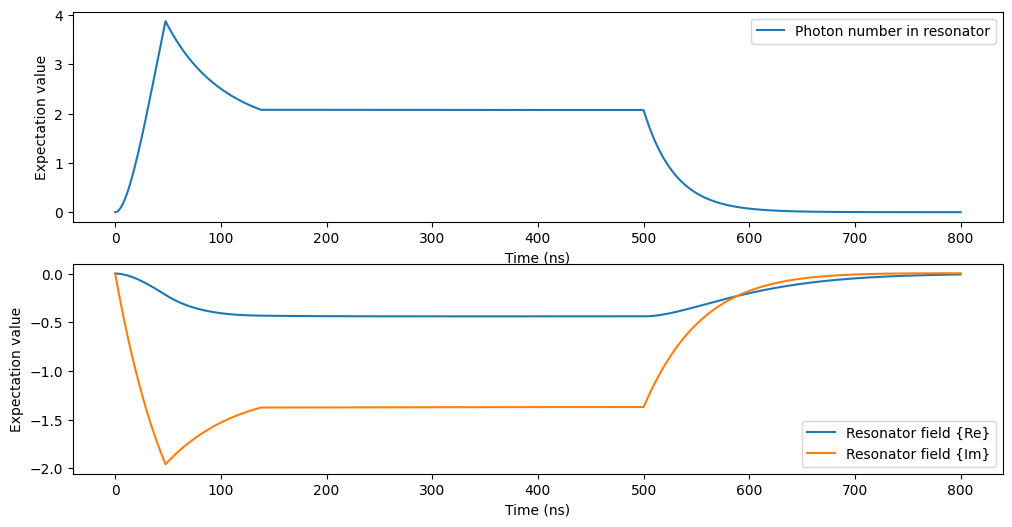

In [29]:
params = res.result.xbest

def simulate_populate_exp(ringup_time, ringdown_time, ringup_norm, ringdown_norm, drive_norm):

    ringup_amp = np.sqrt(ringup_norm * drive_power)  # Amplitude of the ring-up pulse
    drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
    ringdown_amp = np.sqrt(ringdown_norm * drive_power)  # Amplitude of the ring-down pulse

    def drive_pulse(t, args):
        if t<=ringup_time:
            return ringup_amp
        elif t <= ringup_time + ringdown_time:
            return ringdown_amp
        elif t <= 500:
            return drive_amp
        else:
            return 0.0

    HD = [(a + a.dag()), drive_pulse]
    H = [H0, HD]

    # Calculate the expectation values of the measurement operators
    tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
    expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

    # Extract the expectation values
    expectation_values = [expectations.expect[i] for i in range(len(e_ops))]

    return expectation_values

optimal_expectation_values = simulate_populate_exp(*params)

print(f"Stabilisation optimal ringup_time: {params[0]} ns, ringdown_time {params[1]} ns, ringup_norm {params[2]}, ringdown_norm {params[3]}, drive_norm {params[4]}")

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tlist, optimal_expectation_values[0], label='Photon number in resonator')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tlist, np.real(optimal_expectation_values[1]), label='Resonator field {Re}')
plt.plot(tlist, np.imag(optimal_expectation_values[1]), label='Resonator field {Im}')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.show()

In [53]:
# === Your Cost Function ===
def reset_cost(params):
    params = np.append(params, 2.0615066563271975)
    cost = simulate_reset(*params)
    print(f"Params: {params} → Cost: {cost if cost is not None else 'N/A'}")

    return cost

# === Parameter Bounds ===
bounds = [(1, 80),      # Ringup time
          (1, 80),      # Ringdown time
          (1, 15),        # Ringup norm
          (1, 15),        # Ringdown norm
          ]        # Drive norm

# Extract separate lower and upper bound lists
lower_bounds, upper_bounds = zip(*bounds)

# === Initial Guess and Sigma ===
x0 = [(low + high) / 3 for low, high in bounds]  # Midpoint
# sigma = [1.0, 1.0, 0.5, 0.5, 0.5]  # Step size (can be scalar or list per parameter)
sigmas = [(high - low) * 0.1 for (low, high) in bounds]

# === CMA-ES Optimization ===
es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=0.3,
    inopts={
        'bounds': [list(lower_bounds), list(upper_bounds)],
        'maxiter': 100,
        'CMA_stds': sigmas,
        'verb_disp': 1,
    }
)

# Run the optimization
res = es.optimize(reset_cost)

# Best solution and its cost
# ringup_time, ringdown_time, ringup_norm, ringdown_norm, drive_norm
print("Best reset parameters:", res.result.xbest)
print("Best reset time:", res.result.fbest)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=718974, Wed Jun 11 03:37:08 2025)
Params: [23.96787021 28.95683805  5.02009749  5.90571255  2.06150666] → Cost: 234.89186148268539
Params: [28.16727175 27.90504339  5.33284361  5.42934973  2.06150666] → Cost: inf
Params: [25.78314557 25.90249261  5.35937995  5.93638398  2.06150666] → Cost: 246.09326165770722
Params: [27.47320943 25.9335967   5.00269058  4.75849248  2.06150666] → Cost: inf
Params: [30.12137762 28.79551773  6.56144698  4.85898875  2.06150666] → Cost: inf
Params: [29.19119747 26.59733371  5.63438725  5.69677148  2.06150666] → Cost: inf
Params: [27.44706132 25.70424817  5.39331537  5.67915688  2.06150666] → Cost: inf
Params: [26.57836659 28.17505165  4.99268531  5.54837428  2.06150666] → Cost: 245.19314914364293
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.348918614826854e+02 1.0e+00 3.14e-01  4e-01  3e+00 0:04.0


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [1, 3, 4, 5, 6] are not finite but [inf, inf, inf, inf, inf]. (time=Jun 11 03:37:12 2025 class=CMAEvolutionStrategy method=ask)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [28.59156811 26.5391095   5.42286295  5.03061569  2.06150666] → Cost: inf
Params: [25.29499245 23.47937286  5.65399564  5.40015358  2.06150666] → Cost: inf
Params: [28.39801689 27.67854929  4.80000765  5.87019828  2.06150666] → Cost: 248.2935366920865
Params: [23.1807696  31.36437444  4.33201696  5.93345654  2.06150666] → Cost: 222.69033629203648
Params: [25.491381   27.67374197  5.78011666  5.62887841  2.06150666] → Cost: 246.79334916864605
Params: [23.74062678 25.73119805  4.70408222  5.84373899  2.06150666] → Cost: 236.992124015502
Params: [27.17236044 29.33358349  4.71380453  5.73439752  2.06150666] → Cost: 242.99287410926365
Params: [26.33966911 28.27529265  4.78883771  5.90034007  2.06150666] → Cost: 241.59269908738588
    2     16 2.226903362920365e+02 1.5e+00 3.67e-01  5e-01  3e+00 0:08.1


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1] are not finite but [inf, inf]. (time=Jun 11 03:37:16 2025 class=CMAEvolutionStrategy method=ask iteration=1)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.11/dist-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Params: [29.12641229 29.98697     5.23169512  5.44383714  2.06150666] → Cost: inf
Params: [24.14006314 32.47904653  3.26713072  6.74220604  2.06150666] → Cost: 206.58832354044262
Params: [22.56539588 25.77161139  5.72650721  4.96973916  2.06150666] → Cost: 242.59282410301284
Params: [25.88999374 23.36103981  5.32497611  4.90971062  2.06150666] → Cost: inf
Params: [24.00489708 26.77066843  5.24959568  5.31717901  2.06150666] → Cost: 241.79272409051134
Params: [25.6395617  32.71643004  4.428828    6.76797432  2.06150666] → Cost: 224.79059882485308
Params: [24.00979746 30.96315079  3.41109378  5.3929479   2.06150666] → Cost: 221.49018627328417
Params: [21.65856437 32.19235929  4.83367689  5.93709639  2.06150666] → Cost: 218.98987373421676
    3     24 2.065883235404426e+02 1.6e+00 4.91e-01  7e-01  4e+00 0:12.9


/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 3] are not finite but [inf, inf]. (time=Jun 11 03:37:21 2025 class=CMAEvolutionStrategy method=ask iteration=2)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [23.64440221 31.72786264  3.51102034  6.49241654  2.06150666] → Cost: 211.68896112014
Params: [21.2931813  39.22437589  3.80304275  6.25706252  2.06150666] → Cost: 178.78484810601321
Params: [20.93672    21.76393388  4.5314462   6.88067297  2.06150666] → Cost: 230.49131141392672
Params: [24.68680573 39.28395932  3.48185395  5.26837776  2.06150666] → Cost: 206.6883360420053
Params: [17.98952583 34.3480913   5.20255954  6.17500949  2.06150666] → Cost: 196.58707338417298
Params: [21.07589519 34.41740825  3.78163468  4.83639831  2.06150666] → Cost: 211.2889111138893
Params: [17.95447657 33.95728975  2.51318896  7.16952456  2.06150666] → Cost: 160.98262282785345
Params: [26.42752592 30.14918927  4.28394487  5.66728027  2.06150666] → Cost: 236.8921115139392
    4     32 1.609826228278534e+02 1.5e+00 6.55e-01  9e-01  5e+00 0:16.8
Params: [24.98197852 29.87396702  3.26013103  7.66158074  2.06150666] → Cost: 211.08888611076384
Params: [17.89701702 31.50377342  3.99213563  5.87528322  2.

Reset optimal ringup_time: 20.668371079660396 ns, ringdown_time 44.48693108893437 ns, ringup_norm 12.242809267406063, ringdown_norm 14.632117912321677, drive_norm 2.0615066563271975


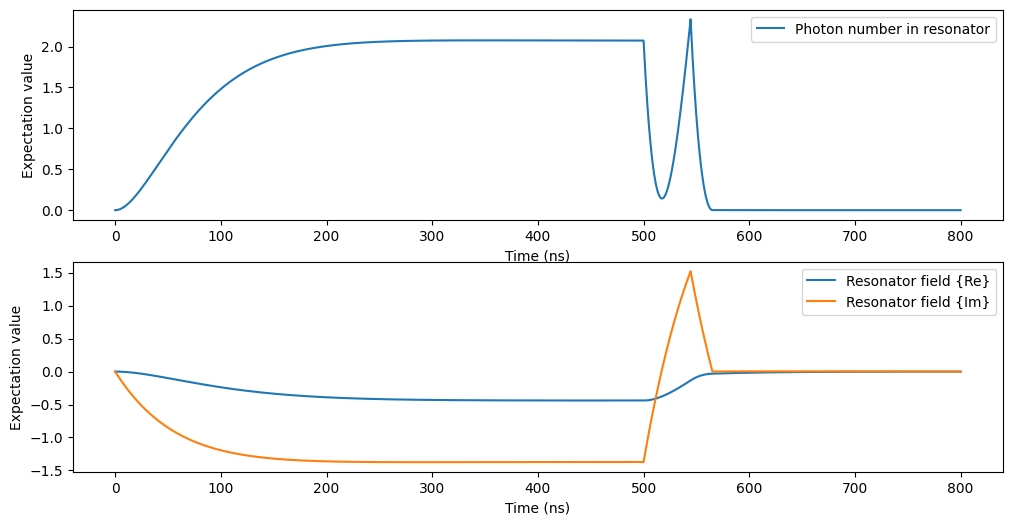

In [55]:
params = res.result.xbest
params = np.append(params, 2.0615066563271975)

def simulate_reset_exp(ringup_time, ringdown_time, ringup_norm, ringdown_norm, drive_norm):

    ringup_amp = np.sqrt(ringup_norm * drive_power)  # Amplitude of the ring-up pulse
    drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
    ringdown_amp = -np.sqrt(ringdown_norm * drive_power)  # Amplitude of the ring-down pulse

    def drive_pulse_rst(t, args):
        if t<=500:
            return drive_amp
        elif t <= 500 + ringdown_time:
            return ringdown_amp
        elif t <= 500 + ringdown_time + ringup_time:
            return ringup_amp
        else:
            return 0.0

    HD = [(a + a.dag()), drive_pulse_rst]
    H = [H0, HD]

    # Calculate the expectation values of the measurement operators
    tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
    expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

    # Extract the expectation values
    expectation_values = [expectations.expect[i] for i in range(len(e_ops))]

    return expectation_values

optimal_expectation_values = simulate_reset_exp(*params)

print(f"Reset optimal ringup_time: {params[0]} ns, ringdown_time {params[1]} ns, ringup_norm {params[2]}, ringdown_norm {params[3]}, drive_norm {params[4]}")

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tlist, optimal_expectation_values[0], label='Photon number in resonator')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tlist, np.real(optimal_expectation_values[1]), label='Resonator field {Re}')
plt.plot(tlist, np.imag(optimal_expectation_values[1]), label='Resonator field {Im}')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.show()

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


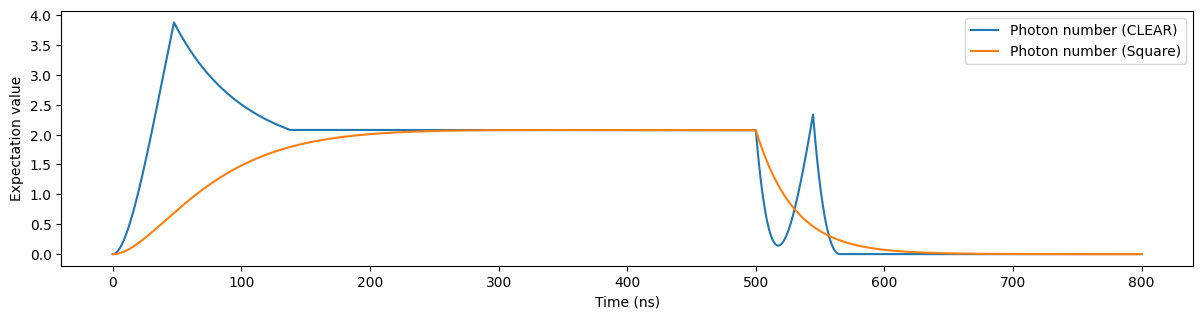

In [4]:
# Full CLEAR signal and photon response using optimal ring-up and ring-down times
drive_power = 4.984375000000001e-05 * 2 * np.pi

ringup1_norm = 11.58332303322993
ringdown1_norm = 1.6156046841062026
ringup1_amp = np.sqrt(ringup1_norm * drive_power)  # Amplitude of the ring-up pulse
ringdown1_amp = np.sqrt(ringdown1_norm * drive_power)  # Amplitude of the ring-down pulse

ringup2_norm = 12.242809267406063
drive_norm = 2.0615066563271975
ringdown2_norm = 14.632117912321677
ringup2_amp = np.sqrt(ringup2_norm * drive_power)  # Amplitude of the ring-up pulse
drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
ringdown2_amp = -np.sqrt(ringdown2_norm * drive_power)  # Amplitude of the ring-down pulse

optimal_ringup1_time = 47.6257865352412
optimal_ringdown1_time = 90.36540617777688
optimal_ringup2_time = 20.668371079660396
optimal_ringdown2_time = 44.48693108893437


def CLEAR_pulse(t, args):
    if t<=optimal_ringup1_time:
        return ringup1_amp
    elif t <= optimal_ringup1_time + optimal_ringdown1_time:
        return ringdown1_amp
    elif t <= 500:
        return drive_amp
    elif t <= 500 + optimal_ringdown2_time:
        return ringdown2_amp
    elif t <= 500 + optimal_ringdown2_time + optimal_ringup2_time:
        return ringup2_amp
    else:
        return 0.0

def drive_pulse(t, args):
    return drive_amp if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD_CLEAR = [(a + a.dag()), CLEAR_pulse]
H_CLEAR = [H0, HD_CLEAR]

HD_drive = [(a + a.dag()), drive_pulse]
H_drive = [H0, HD_drive]

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_CLEAR = mesolve(H_CLEAR, psi0, tlist, c_ops, e_ops)
expectations_square = mesolve(H_drive, psi0, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values_CLEAR = [expectations_CLEAR.expect[i] for i in range(len(e_ops))]
expectation_values_square = [expectations_square.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tlist, expectation_values_CLEAR[0], label='Photon number (CLEAR)')
plt.plot(tlist, expectation_values_square[0], label='Photon number (Square)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.tight_layout()
plt.show()

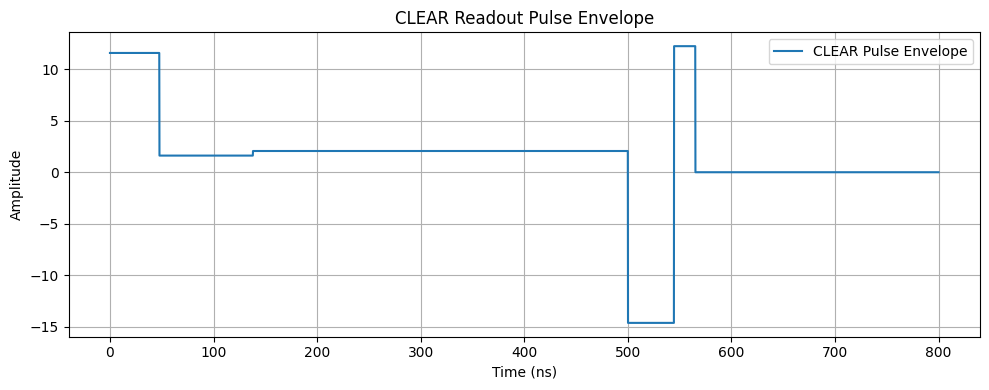

In [5]:
# Plot the CLEAR pulse envelope

envelope = [np.sign(CLEAR_pulse(t, None) ) * (CLEAR_pulse(t, None) / np.sqrt(drive_power))**2 for t in tlist]
plt.figure(figsize=(10, 4))
plt.plot(tlist, envelope, label='CLEAR Pulse Envelope')
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.title("CLEAR Readout Pulse Envelope")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [60]:
# Determine steady state time and reset time for a CLEAR pulse
steady_state_time_CLEAR = find_steady_state_time(tlist, expectation_values_CLEAR[0])
reset_time_CLEAR = find_cavity_reset_time(tlist, expectation_values_CLEAR[0])
print(f"CLEAR Pulse Steady state duration: {steady_state_time_CLEAR} ns")
print(f"CLEAR Pulse Cavity reset duration: {reset_time_CLEAR} ns")

# Determine steady state time and reset time for a rectangle pulse
steady_state_time_square = find_steady_state_time(tlist, expectation_values_square[0])
reset_time_square = find_cavity_reset_time(tlist, expectation_values_square[0])
print(f"Square Pulse Steady state duration: {steady_state_time_square} ns")
print(f"Square Pulse Cavity reset duration: {reset_time_square} ns")

CLEAR Pulse Steady state duration: 137.91723965495686 ns
CLEAR Pulse Cavity reset duration: 65.17064633079133 ns
Square Pulse Steady state duration: 314.03925490686333 ns
Square Pulse Cavity reset duration: 227.1908988623578 ns
